## Preparation

In [126]:
!pip install imblearn
!pip install pygam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 5.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.1 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import (
    RocCurveDisplay,
    f1_score,
    classification_report,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_recall_curve
    )
from sklearn.model_selection import (
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_score,
    train_test_split
    )
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import(
    OneHotEncoder,
    StandardScaler,
    PolynomialFeatures,
    MinMaxScaler
    )

from sklearn.feature_selection import (
    SequentialFeatureSelector,
    f_classif,
    SelectKBest,
    VarianceThreshold)


from imblearn.pipeline import Pipeline as imb_pipe
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy.signal import savgol_filter

['Age',
 'Income',
 'LoanAmount',
 'CreditScore',
 'MonthsEmployed',
 'NumCreditLines',
 'InterestRate',
 'LoanTerm',
 'DTIRatio']

In [3]:

data = pd.read_csv("loan_data.csv").drop("LoanID",axis=1)
target=data.pop("Default")

In [4]:
target.value_counts()

Default
0    225694
1     29653
Name: count, dtype: int64

In [3]:

cat_vars=list(data.select_dtypes(include="object").columns)
num_vars=[c for c in data.columns if c not in cat_vars]


In [4]:

X_train, X_test, y_train, y_test = train_test_split(data,target, test_size=0.2, random_state=408,stratify=target)
preprocessor = ColumnTransformer([("one_hot",OneHotEncoder(drop="first"),cat_vars),("standardize",StandardScaler(),num_vars)])


## Utility Functions

In [68]:
def plot_probs(model,X,y,prob_preds=None,**plot_kwargs):
    y_proba=prob_preds if prob_preds is not None else [x[1] for x in model.predict_proba(X)]
    pred_data=pd.DataFrame({"Predicted Probability":y_proba,"Actual":y})
    sns.histplot(data=pred_data,x="Predicted Probability",hue="Actual",**plot_kwargs)
    plt.show()

In [73]:
def plot_resids_w_avg(clf,X,y,prob_preds=None,window_size=None,poly_order=3):
    y_proba=prob_preds if prob_preds is not None else [x[1] for x in clf.predict_proba(X)]
    pred_data=pd.DataFrame({"Predicted Probability":y_proba,"Actual":y}).sort_values("Predicted Probability")
    residuals=pred_data["Predicted Probability"]-pred_data["Actual"]

    window_size = window_size if window_size is not None else len(X)//50
    residuals_ma = savgol_filter(residuals, window_size, poly_order)

    # Plot residuals versus fitted values
    plt.figure(figsize=(10, 6))
    plt.scatter(pred_data["Predicted Probability"], residuals, color='blue', alpha=0.5, label='Residuals')
    plt.plot(pred_data["Predicted Probability"], residuals_ma, color='red', label='Moving Average', linewidth=2)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Horizontal line at y=0
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

In [74]:
def show_confusion_matrix(clf,X,y,preds=None):
    y_pred=preds if preds is not None else clf.predict(X)
    cm=confusion_matrix(y,y_pred)
    ConfusionMatrixDisplay(cm,display_labels=["No Default","Default"]).plot()
    plt.show()

In [513]:
def show_metrics(clf,X,y):
    y_pred=clf.predict(X)
    y_proba=np.array([x[1] for x in clf.predict_proba(X)])
    print(classification_report(y,y_pred))
    #plot_resids_w_avg(clf,X,y,prob_preds=y_proba)
    plot_probs(clf,X,y,prob_preds=y_proba)
    show_confusion_matrix(clf,X,y,preds=y_pred)
    

## Initial Full Model

In [495]:
basic_model=Pipeline(steps=[
    ("preprocessor",preprocessor),
    ("Classifier",LogisticRegression(penalty=None))])
basic_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Education',
                                                   'EmploymentType',
                                                   'MaritalStatus',
                                                   'HasMortgage',
                                                   'HasDependents',
                                                   'LoanPurpose',
                                                   'HasCoSigner']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['Age', 'Income',
                                                   'LoanAmount', 'CreditScore',
                                                   'MonthsEmployed',
                                                   'NumCreditLines',
                                                   'InterestRate', 'LoanTerm',
                                                   'DTIRatio'])])),
                ('Classifier', LogisticRegression(penalty=None))])

### Cross-validation

In [496]:
cv_scores = cross_val_score(basic_model, X_train,y_train, cv=5, scoring='f1',) 
print("Cross-validation F1 scores:", cv_scores)
print("Mean F1 score:", cv_scores.mean())


Cross-validation F1 scores: [0.0651052  0.06442577 0.05842337 0.06494024 0.06304868]
Mean F1 score: 0.06318865246729632


              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45139
           1       0.61      0.03      0.06      5931

    accuracy                           0.89     51070
   macro avg       0.75      0.52      0.50     51070
weighted avg       0.85      0.89      0.84     51070



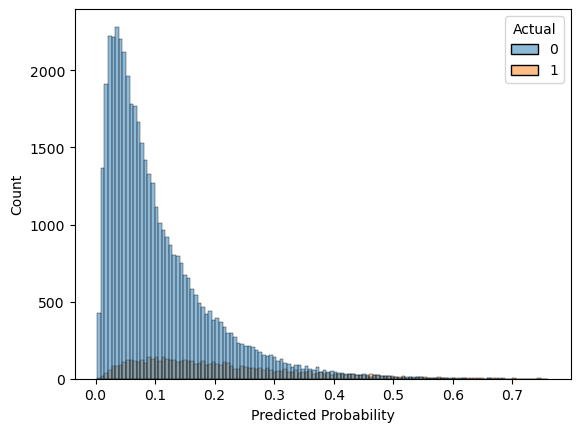

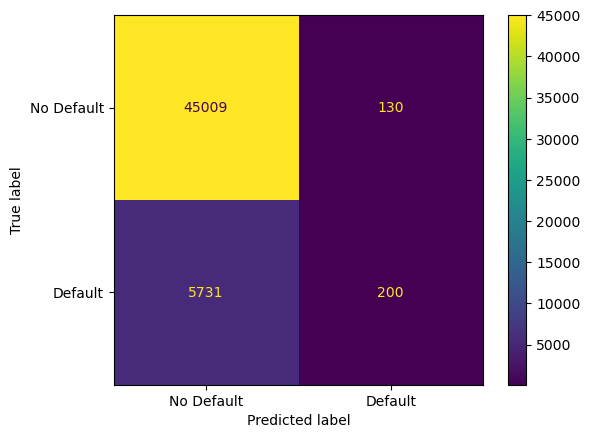

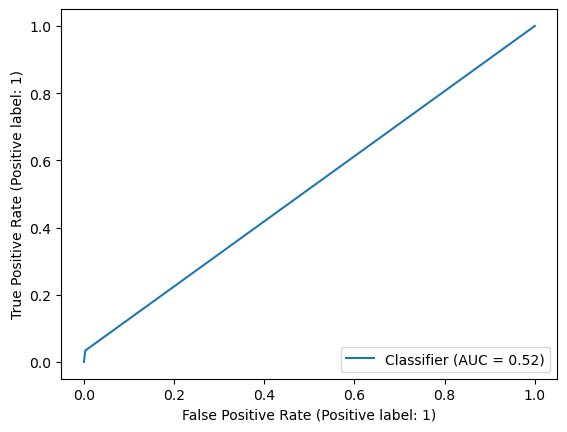

In [499]:
show_metrics(basic_model,X_test,y_test)

### Discussion
- The stable CV scores indicate that high variance does not seem to be an issue. Therefore, we can keep the penalty as `None` for the logistic regression
- We can see that this meets the assumtpion of a fairly constant variance of errors and linearity
- Due to the imbalanced classes, the model overwhelmingly predicts that the person will not default, and is often right


## Oversampling

In [155]:

smote_pipe=imb_pipe(steps=[("preprocessor", preprocessor),
                    ("resampler",SMOTE()),
    ("classifier", LogisticRegression(penalty='l2'))
    ])

smote_pipe.fit(X_train,y_train)
cv_scores = cross_val_score(smote_pipe, X_train,y_train, cv=5, scoring='f1') 
print("Cross-validation F1 scores:", cv_scores)
print("Mean F1 score:", cv_scores.mean())


Cross-validation F1 scores: [0.32813545 0.33462272 0.33412592 0.3329199  0.330433  ]
Mean F1 score: 0.33204739887582874


              precision    recall  f1-score   support

           0       0.94      0.68      0.79     45139
           1       0.22      0.69      0.34      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.68      0.74     51070



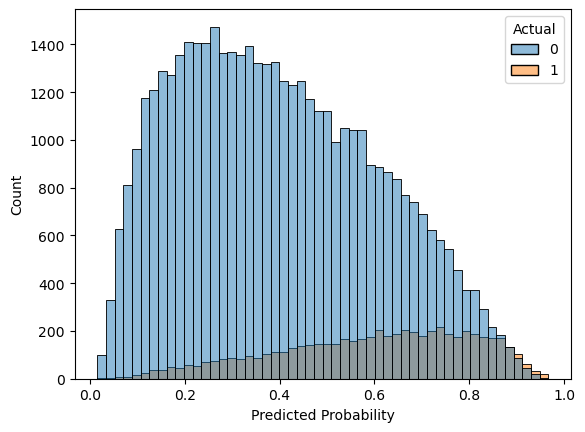

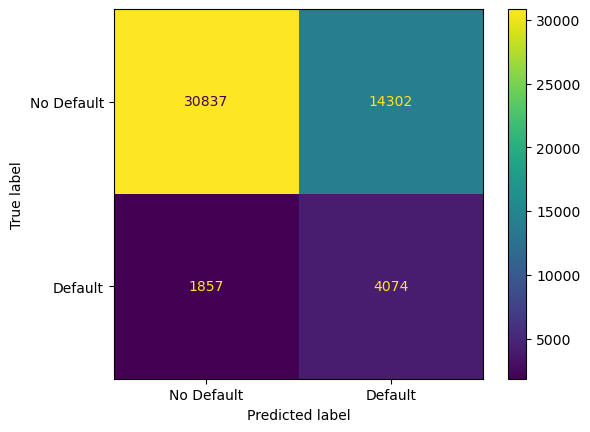

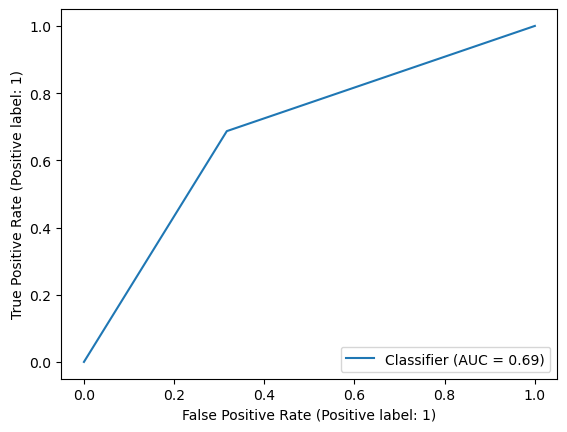

In [512]:
show_metrics(smote_pipe,X_test,y_test)


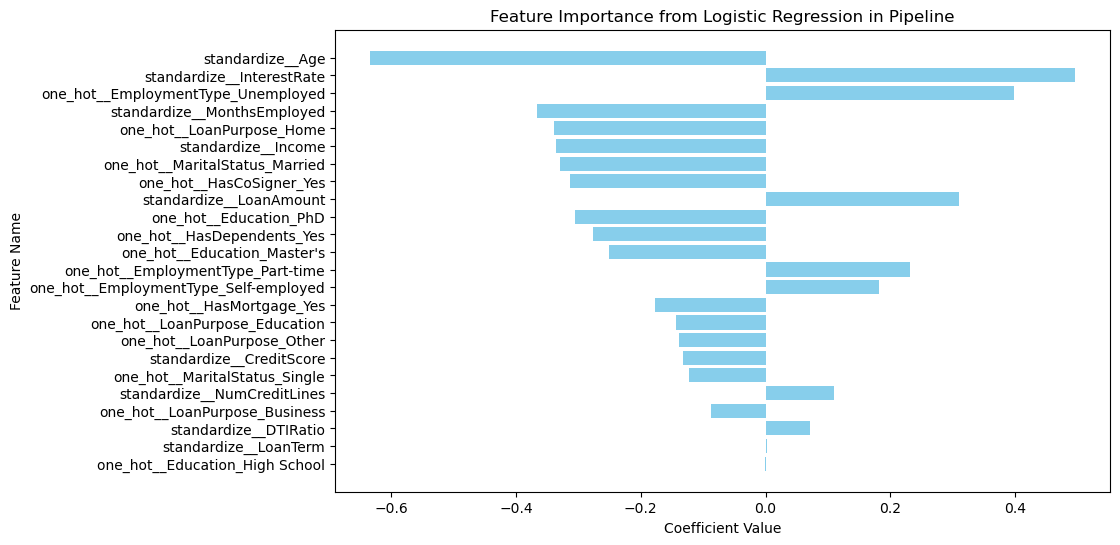

In [145]:
logreg_model = smote_pipe[-1]
feature_names=smote_pipe[-3].get_feature_names_out()
# Retrieve coefficients from the logistic regression model
feature_coef = logreg_model.coef_[0]
abs_feature_coef = np.abs(feature_coef)
sorted_indices = np.argsort(abs_feature_coef)[::-1]  # Sort indices in descending order of absolute coefficient values

# Sort feature names and coefficients accordingly
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_feature_coef = feature_coef[sorted_indices]
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_coef, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
plt.show()

## Undersampling

In [166]:
under_pipe=imb_pipe(steps=[("preprocessor", preprocessor),
                    ("resampler",RandomUnderSampler(random_state=28)),
                    ("classifier", LogisticRegression(penalty=None))
    ])

under_pipe.fit(X_train,y_train)
cv_scores = cross_val_score(under_pipe, X_train,y_train, cv=5, scoring='f1') 
print("Cross-validation F1 scores:", cv_scores)
print("Mean F1 score:", cv_scores.mean())


Cross-validation F1 scores: [0.32681971 0.33223367 0.3318108  0.33156163 0.32876162]
Mean F1 score: 0.3302374858294801


              precision    recall  f1-score   support

           0       0.91      0.92      0.92     45139
           1       0.35      0.32      0.33      5931

    accuracy                           0.85     51070
   macro avg       0.63      0.62      0.63     51070
weighted avg       0.85      0.85      0.85     51070



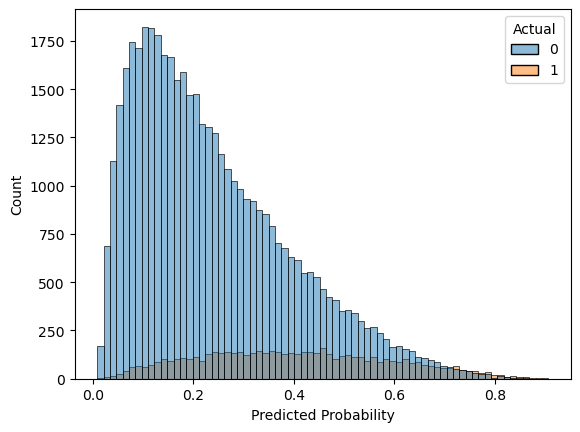

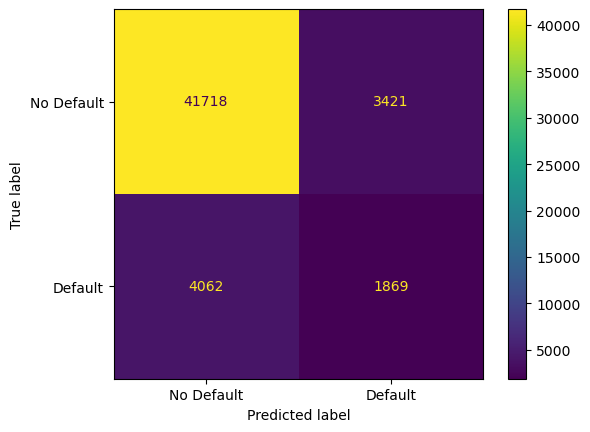

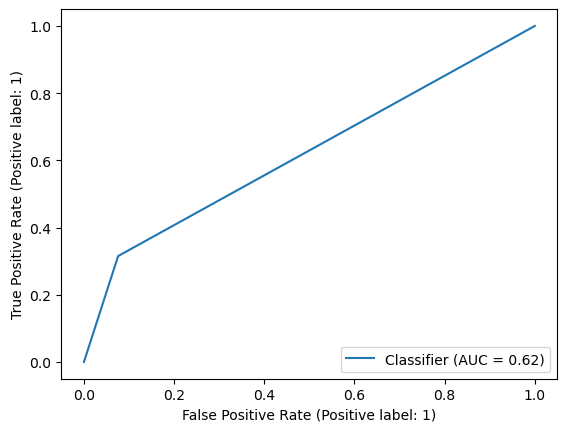

In [500]:
show_metrics(under_pipe,X_test,y_test)

### Choosing proportion


In [501]:
class_proportions=[0.2,0.25, 0.3, 0.35,0.4,0.45,0.5] 
tot=len(y_test)
results={}
for proportion in class_proportions:
    # Set the desired proportion in RandomUnderSampler
    under_pipe.named_steps['resampler'].sampling_strategy =proportion
    under_pipe.fit(X_train,y_train)
    preds=under_pipe.predict(X_test)
    
    report=classification_report(y_test,preds,output_dict=True)
    report['1']['accuracy']=report['accuracy']
    results[proportion]=report['1']
    



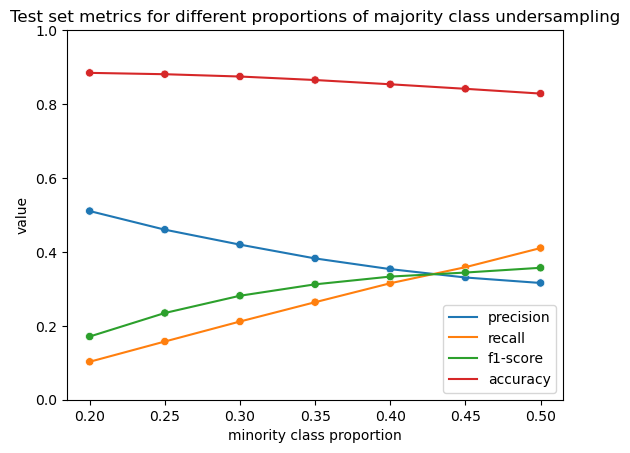

In [502]:
result_df=pd.DataFrame(results).transpose().reset_index().rename(columns={"index":"minority class proportion"}).drop("support",axis=1)
melted=result_df.melt(id_vars=["minority class proportion"],var_name="metric")
sns.lineplot(data=melted,x="minority class proportion",y="value",hue="metric")
sns.scatterplot(data=melted,x="minority class proportion",y="value",hue="metric",legend=None)
plt.title("Test set metrics for different proportions of majority class undersampling")
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.show()


### Plotting decision thresholds

In [379]:
chosen_proportion=0.4
under_pipe.named_steps['resampler'].sampling_strategy = chosen_proportion
under_pipe.fit(X_train,y_train)
probs=np.array([x[1] for x in under_pipe.predict_proba(X_test)])
   
precision,recall, threshold=precision_recall_curve(y_test,probs)
accuracies=[]
tot=len(y_test)
accuracies=[round(np.sum((probs>t)==y_test)/tot,3) for t in threshold]
f1=((precision * recall)/(precision+recall))[:-1]
df=pd.DataFrame({"precision":precision[:-1],
                 "recall":recall[:-1],
                 "accuracy":accuracies,
                 "threshold":threshold,
                 "f1":f1}).melt(id_vars="threshold",var_name="metric")


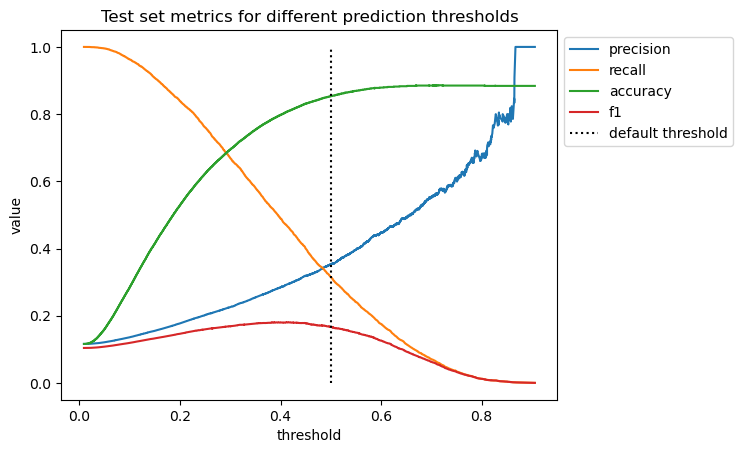

In [380]:
ax=sns.lineplot(data=df,x='threshold',hue='metric',y='value')
#sns.move_legend(ax,"upper left", bbox_to_anchor=(1, 1))
plt.vlines(0.5,0,1,colors='black',linestyles='dotted',label='default threshold')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("Test set metrics for different prediction thresholds")
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.88      0.90    180555
           1       0.31      0.41      0.35     23722

    accuracy                           0.83    204277
   macro avg       0.61      0.64      0.63    204277
weighted avg       0.85      0.83      0.84    204277



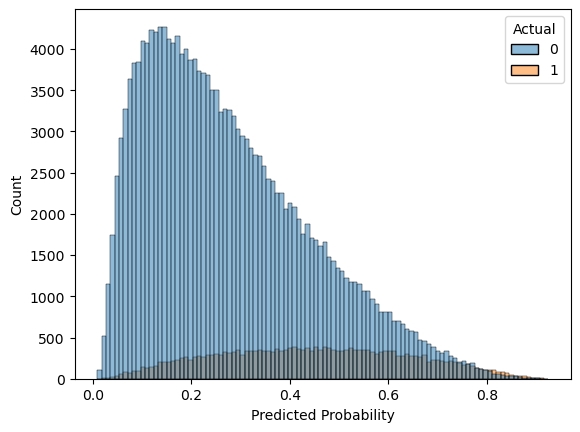

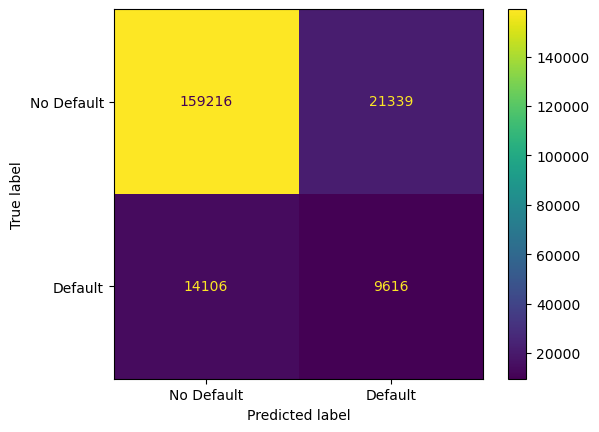

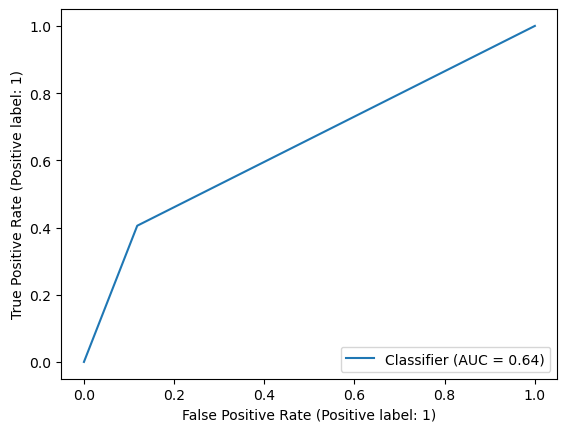

In [503]:
show_metrics(under_pipe,X_train,y_train)

#### Feature Importance

In [ ]:
corr_df=pd.DataFrame(transformed,columns=features).corr().reset_index().rename(columns={'index':'var1'}).melt(id_vars='var1',var_name='var2',value_name='r')
corr_df["r^2"]=corr_df["r"]**2
corr_df_filtered=corr_df[corr_df['r'].apply(lambda x: x!=1 and abs(x)>0.1)==True].drop_duplicates('r')
corr_df_filtered.sort_values('r^2',ascending=False)


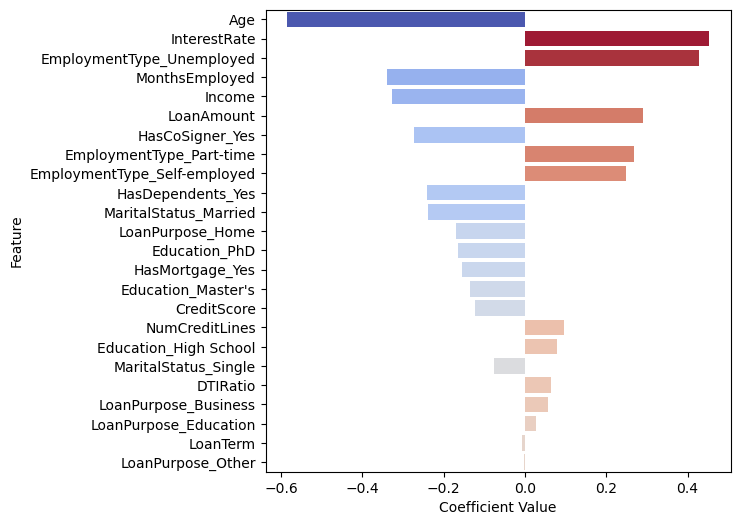

In [510]:
features=under_pipe[:-1].get_feature_names_out()
coefs=under_pipe.named_steps["classifier"].coef_[0,:]
df=pd.DataFrame({"Feature":under_pipe[:-1].get_feature_names_out(),"Coefficient Value":coefs})
df["Feature"]=df["Feature"].apply(lambda x:x.replace("standardize__","").replace("one_hot__",""))
df['abs']=df["Coefficient Value"].apply(np.abs)
df=df.sort_values("abs",ascending=False)
plt.figure(figsize=(6,6))
fig=sns.barplot(y="Feature",x="Coefficient Value",data=df,hue="Coefficient Value",palette='coolwarm',legend=False)


### Choosing Polynomial Features and Narrowing Down

In [5]:

poly = PolynomialFeatures(degree=2,include_bias=False,interaction_only=True)
results=[]
narrow_selector= SelectKBest(score_func=f_classif,k=100)
pipe= imb_pipe(steps=[
    ("preprocessor", preprocessor),
    ("resampler",RandomUnderSampler(sampling_strategy=0.4,random_state=741)),
    ("polynomial features",poly),
    ("variance threshold",VarianceThreshold()),
    #("k best features",narrow_selector),
    ("classifier", LogisticRegression(penalty=None,max_iter=5000,solver='saga'))
    ]
    )
pipe.fit(X_train,y_train)
    


NameError: name 'preprocessor' is not defined

In [518]:
len(pipe[-3].get_feature_names_out())

287

In [440]:
k_results={}
for num in range(10,210,10):
    pipe.named_steps['k best features'].k=num
    pipe.fit(X_train,y_train)
    
    preds=pipe.predict(X_test)
    
    report=classification_report(y_test,preds,output_dict=True)
    report['1']['accuracy']=report['accuracy']
    k_results[num]=report['1']



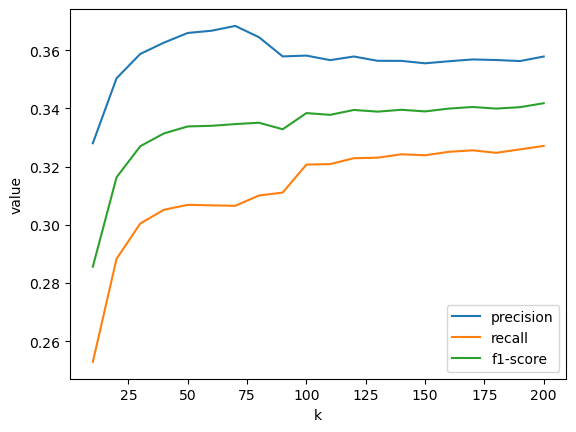

In [441]:
k_result_df=pd.DataFrame(k_results).transpose().reset_index().rename(columns={"index":"k"}).drop(["support",'accuracy'],axis=1)
k_melted=k_result_df.melt(id_vars=["k"],var_name="metric")
sns.lineplot(data=k_melted,x="k",y="value",hue="metric")

#plt.title("Test set metrics for different proportions of majority class undersampling")
plt.legend(loc='lower right')
plt.show()

In [491]:
best_num=30
pipe.named_steps['k best features'].k=best_num
pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Education',
                                                   'EmploymentType',
                                                   'MaritalStatus',
                                                   'HasMortgage',
                                                   'HasDependents',
                                                   'LoanPurpose',
                                                   'HasCoSigner']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['Age', 'Income',
                                                   'LoanAmount', 'CreditScore',
                                                   'MonthsEmployed',
                                                   'NumCreditLines',
                                                   'InterestRate', 'LoanTerm',
                                                   'DTIRatio'])])),
                ('resampler',
                 RandomUnderSampler(random_state=741, sampling_strategy=0.4)),
                ('polynomial features',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('variance threshold', VarianceThreshold()),
                ('k best features', SelectKBest(k=30)),
                ('classifier',
                 LogisticRegression(max_iter=5000, penalty=None,
                                    solver='saga'))])

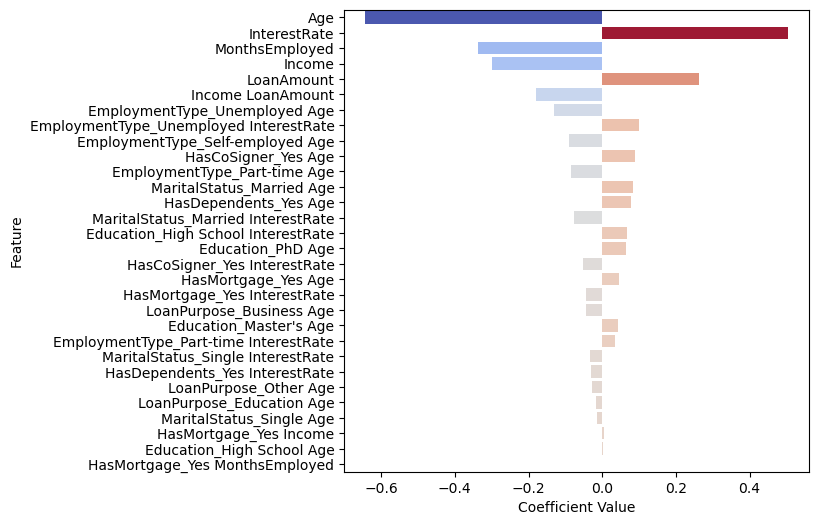

In [508]:
features=pipe[:-1].get_feature_names_out()
coefs=pipe.named_steps["classifier"].coef_[0,:]
df=pd.DataFrame({"Feature":pipe[:-1].get_feature_names_out(),"Coefficient Value":coefs})
df["Feature"]=df["Feature"].apply(lambda x:x.replace("standardize__","").replace("one_hot__",""))
df['abs']=df["Coefficient Value"].apply(np.abs)
df=df.sort_values("abs",ascending=False)
plt.figure(figsize=(6,6))
fig=sns.barplot(y="Feature",x="Coefficient Value",data=df,hue="Coefficient Value",palette='coolwarm',legend=None)


              precision    recall  f1-score   support

           0       0.91      0.93      0.92     45139
           1       0.36      0.30      0.33      5931

    accuracy                           0.86     51070
   macro avg       0.63      0.61      0.62     51070
weighted avg       0.85      0.86      0.85     51070



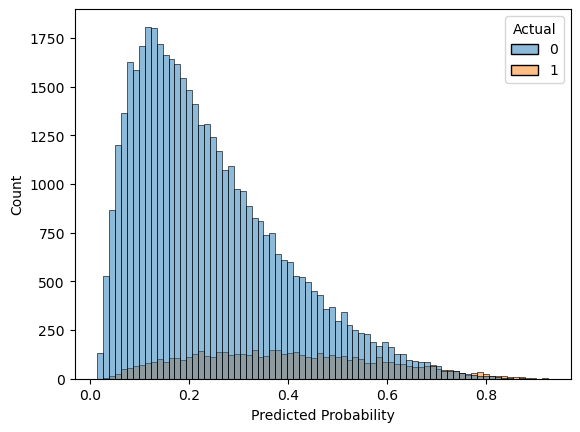

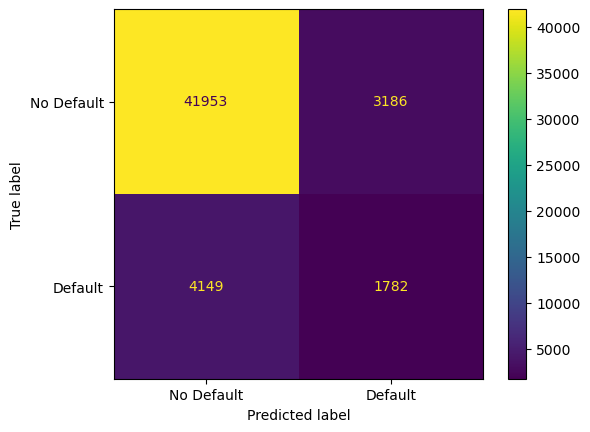

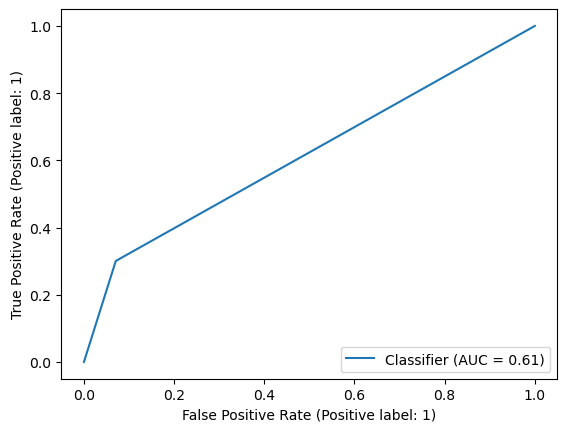

In [511]:
show_metrics(pipe,X_test,y_test)